<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training an Image Segmentation Model

In this notebook, we show how to train and evaluate an image segmentation model using a Unet architecture based on the [fast.ai](https://www.fast.ai/) library.

We distinguish between semantic and instance segmentation. Instance segmentation aims to find and segment different objects in an image - we showed how to solve such problems in the [02_mask_rcnn.ipynb](../detection/02_mask_rcnn.ipynb) notebook. 

In this notebook, we are interested in semantic segmentation, which classifies each pixel in an image by object class. Using a small dataset of four different beverage packages, we demonstrate how to train and evaluate such models.

<img src="../detection/media/segmentaion_comparison.png" width="1000"/>



## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all the functions we need.

In [2]:
import sys
sys.path.append("../../")
from pathlib import Path
import urllib

import fastai
from fastai.vision import *
import numpy as np
import scrapbook as sb

from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import db_num_workers, which_processor
from utils_cv.segmentation.data import Urls
from utils_cv.segmentation.dataset import read_classes
from utils_cv.segmentation.model import get_objective_fct, predict, confusion_matrix, print_accuracies
from utils_cv.segmentation.plot import plot_image_and_mask, plot_mask_stats, plot_segmentation, plot_confusion_matrix

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.57
Torch is using GPU: Tesla K80


This shows your machine's GPUs (if has any) and the computing device `fastai/torch` is using. 

Next, set some model runtime parameters. We use the `unzip_url` helper function to download and unzip the data used in this example notebook. Some tips with regards to inference speed / accuracy:
- Improve accuracy using deeper model (e.g. resnet50) or more training epochs
- Improve inference speed user lower resolution, however at same aspect ratio as the original image
- Reduce batch size if the model does not fit into memory

In [3]:
# Path to data
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)

# Model and inference parameters
IM_SIZE = [200, 150]
BATCH_SIZE = 8
ARCHITECTURE = models.resnet18
THRESHOLD = None

# Training parameters
EPOCHS_HEAD = 3
EPOCHS_FULL = 15  # 30
LEARNING_RATE = 1e-4

---

# Prepare Dataset

In this notebook, we use a toy dataset specified in DATA_PATH which consists of 129 images of 4 classes of beverage containers `{can, carton, milk bottle, water bottle}`. For each image, a pixel-wise ground-truth mask is provided for training and evaluation. 

In [4]:
DATA_PATH = Path(DATA_PATH)
DATA_PATH.ls()

[WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/classes.txt'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/images'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/segmentation-masks')]

You'll notice that `DATA_PATH` contains two subfolders and one file:
- `/images`
- `/segmentation-masks`
- `classes.txt`

This is a common data structure for image segmentation. The two folders use the same filename to indicate which mask corresponds to which image. 

In [5]:
im_path = DATA_PATH / "images"
im_paths = sorted(get_image_files(im_path))
im_paths[:3]

[WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/images/1.jpg'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/images/10.jpg'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/images/100.jpg')]

In [6]:
anno_path = DATA_PATH / "segmentation-masks"
mask_paths = sorted(get_image_files(anno_path))
mask_paths[:3]

[WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/segmentation-masks/1.png'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/segmentation-masks/10.png'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/segmentation-masks/100.png')]

<class 'fastai.vision.image.Image'>
<class 'fastai.vision.image.ImageSegment'>


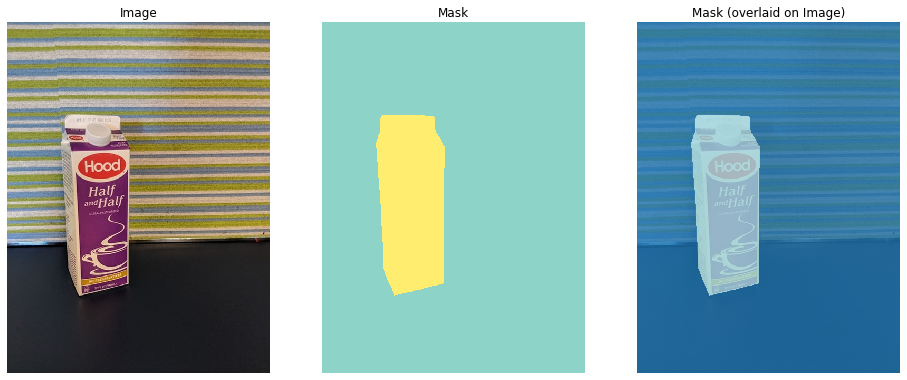

In [7]:
plot_image_and_mask(im_paths[0], mask_paths[0], alpha=0.8)

The masks in `segmentation-masks` contain at each pixel the id of the object. In our case, id 0 corresponds to "background", 1 to "can", 2 to "carton", 3 to "milk_bottle" and 4 to "water_bottle". This mapping from id to class name is defined in the file `classes.txt`. 

In [8]:
classes_path = DATA_PATH / "classes.txt"
classes = read_classes(classes_path)
print(classes)

['background', 'can', 'carton', 'milk_bottle', 'water_bottle']


Note that the masks in `segmentation-masks` appear fully black when opening with an image viewer. This is because the maximum pixel-value in our masks is 4 (the id for "water_bottle") however the color white corresponds to a value 255 in PNG files. 

When annotating images, some pixels can be ambiguous or time-consuming to annotate (e.g. object boundaries for the [pets](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset).  In such cases, one can label these pixels with the special class "void". Pixels marked as "void" will then be ignored during model training. For more details see the implementation of `get_objective_fct()` in [utils_cv\segmentation\model.py](../../utils_cv/segmentation/model.py).

# Load Images

For training and validation, we randomly split the data in an `8:2` ratio, holding 80% of the data for training and 20% for validation. One can also create dedicated train-test splits using e.g. fastai's `split_by_folder()` or `split_by_fname_file()` functions.

In [9]:
# Define function which, given as input a path to an image, returns the corresponding path to its mask
get_gt_filename = lambda x: anno_path / f"{x.stem}.png"

# Load data
data = (
    SegmentationItemList.from_folder(im_path)
    # .split_by_fname_file('../valid.txt')
    .split_by_rand_pct(valid_pct=0.2, seed=10)
    .label_from_func(get_gt_filename, classes=classes)
    .transform(get_transforms(), size=IM_SIZE, tfm_y=True)
    .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
    .normalize(imagenet_stats)
)

Show the number of images in the training and validation sets.

In [10]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (103 items)
x: SegmentationItemList
Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150)
y: SegmentationLabelList
ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150)
Path: C:\Users\pabuehle\Desktop\computervision-recipes\data\segFridgeObjects\images;

Valid: LabelList (25 items)
x: SegmentationItemList
Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150)
y: SegmentationLabelList
ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150)
Path: C:\Users\pabuehle\Desktop\computervision-recipes\data\segFridgeObjects\images;

Test: None>

Show all available classes:

In [11]:
print(f"Number of images: {len(data.y.items)}")
print(f"Classes: {data.classes}")

Number of images: 103
Classes: ['background', 'can', 'carton', 'milk_bottle', 'water_bottle']


We examine some sample data using the `databunch` we created.

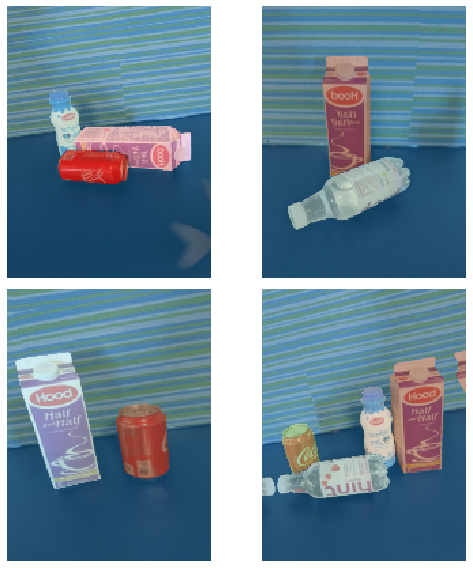

In [12]:
data.show_batch(rows=2)

Finally, some information about the provided ground truth masks. The plot on the left shows the number of segments for each class within the masks, and the plot on the right further visualizes the size of the segments. Note that because of e.g. occlusions a single object can be split into multiple segments, which is why in our dataset we see some segments with only very few pixels. 


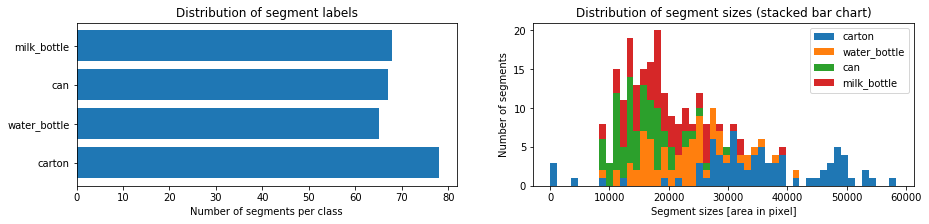

In [13]:
plot_mask_stats(data, classes, figsize=(15,3), exclude_classes = ['background'])

# Train a Model

Our image segmentation model is based on a [UNet](https://docs.fast.ai/vision.models.unet.html) architecture with an [ImageNet](http://www.image-net.org/) pre-trained Resnet-18 backbone.

We use fastai's `unet_learner()` function to obtain a UNet object. The objective function to be maximised during training is specified via `metrics` as the ratio of correctly classified pixels.

In [14]:
learn = unet_learner(
    data, 
    ARCHITECTURE, 
    wd=1e-2, 
    metrics=get_objective_fct(classes)
)

At first we only train the last layers to provide a rough initialization of the UNet model. 

epoch,train_loss,valid_loss,_objective_fct_partial,time
0,1.022092,0.536408,0.843563,00:26
1,0.628385,0.213591,0.914336,00:09
2,0.454105,0.165276,0.935829,00:09


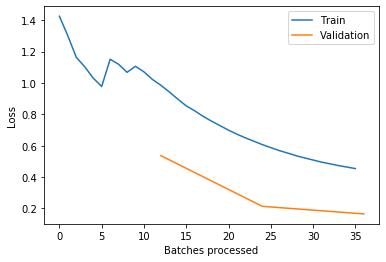

In [15]:
learn.fit_one_cycle(EPOCHS_HEAD, 10*LEARNING_RATE) #slice(LEARNING_RATE), pct_start=0.9)
learn.recorder.plot_losses()

Next, we train all the CNN layers by using the `unfreeze` method.

In [16]:
learn.unfreeze()

epoch,train_loss,valid_loss,_objective_fct_partial,time
0,0.186854,0.162712,0.934479,00:10
1,0.184815,0.146638,0.942319,00:10
2,0.172057,0.106142,0.961991,00:09
3,0.152745,0.096226,0.963916,00:09
4,0.136942,0.075698,0.972213,00:10
5,0.120446,0.051468,0.982448,00:09
6,0.103340,0.050008,0.982809,00:09
7,0.090156,0.040809,0.985340,00:09
8,0.079653,0.037314,0.986580,00:09
9,0.070429,0.033971,0.987340,00:10


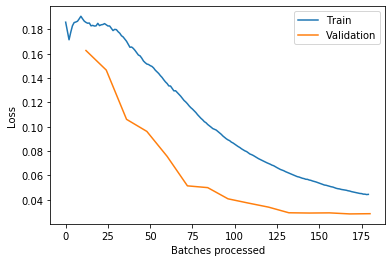

In [17]:
learn.fit_one_cycle(EPOCHS_FULL, LEARNING_RATE) #slice(LEARNING_RATE/100,LEARNING_RATE) , pct_start=0.8)
learn.recorder.plot_losses()

Lastly we visualize some of the predictions on the validation set. 

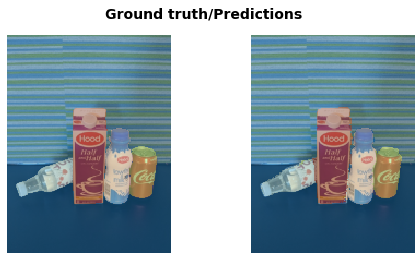

In [18]:
learn.show_results(rows=1)

# Validate the model

This section provides a quantitative analysis of the trained model. We report the overall accuracy (ie ratio of correctly classified pixels), as well as the accuracy for each class. 

In [20]:
cmat, cmat_norm = confusion_matrix(learn, data.valid_dl)
accs = print_accuracies(cmat, cmat_norm, classes)

Overall accuracy: 98.92%
Class-averaged accuracy: 96.39%
	Class      background has accuracy: 99.62%
	Class             can has accuracy: 96.51%
	Class          carton has accuracy: 93.78%
	Class     milk_bottle has accuracy: 96.44%
	Class    water_bottle has accuracy: 95.63%


More insights into the model performance can be obtained from the confusion matrix. For each class, the matrix lists the number of pixels with correctly predicted labels along the diagonal, and incorrect pixels off-diagonal. This allows a detailed inspection which classes the model confuses.

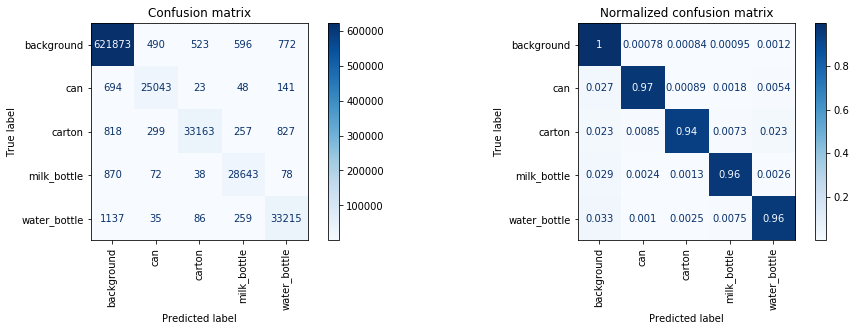

In [21]:
plot_confusion_matrix(cmat, cmat_norm, classes)

# Scoring

The `predict()` and `plot_segmentation()` functions can be used to run the model on a given image, and to visualize the results respectively.

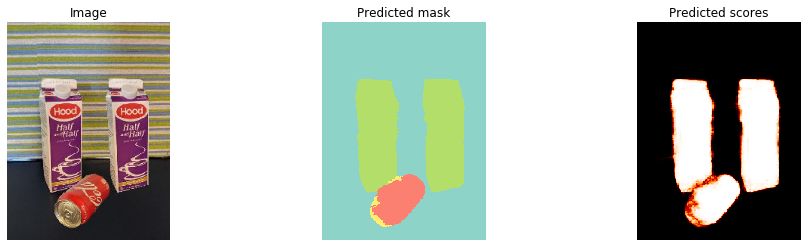

In [22]:
# Download an example image
IM_URL = "https://cvbp.blob.core.windows.net/public/images/cvbp_two_cartons.jpg"
im_path = "example.jpg"
urllib.request.urlretrieve(IM_URL, im_path)

# Run model inference
mask, scores = predict(im_path, learn, thres=0.2)

# Plot results
plot_segmentation(im_path, mask, scores)

The number of pixel assigned to each class in the predicted mask can be seen below.

In [23]:
for i in range(mask.max()+1):
    print(f"Class {classes[i]:>15} has {sum(sum(mask == i)):>6} pixels")

Class      background has  21363 pixels
Class             can has   1454 pixels
Class          carton has   7015 pixels
Class     milk_bottle has      0 pixels
Class    water_bottle has    168 pixels


In [24]:
# Preserve some of the notebook outputs
sb.glue("validation_overall_accuracy", accs[0])
sb.glue("validation_class_accuracies", list(accs[1]))

# Conclusion

Using the concepts introduced in this notebook, you can bring your own dataset and train a model to detect the per-pixel location of objects of interest for your specific setting. 